### Import des librairies

In [1]:
! python -m spacy download fr_core_news_sm
! pip install spacy
! pip install unicode
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
import re
import spacy
import fr_core_news_sm
from wordcloud import WordCloud
from gensim.summarization.summarizer import summarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from stop_words import get_stop_words
from gensim.summarization.summarizer import summarize
import textrank
import gensim
from gensim.models import word2vec
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

[+] Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [2]:
file="LA_TRANSITION_ECOLOGIQUE.csv"
question="QUXVlc3Rpb246MTU4 - Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?"

additional_stop_words = ["assez","comme","depuis","dessus","vers","si","jamais","toujours","le","la",'les',
'etre','plus','sur','sous','contre','non','ni','et','donc','mais','ou','celui','celle','tous','quelque','un'
,'une','abord','jusqu','afin','surtout','apres','non','il','elle','ils','elles','nous','vous','etc']
reduced_reviews = []
#     stops = set(stopwords.words('french'))
stop_words = get_stop_words('fr')
stop_words.extend(additional_stop_words)

In [3]:
trans_eco_df = pd.read_csv(file, sep=',')
trans_eco_df['id'].drop_duplicates(inplace=True)
trans_eco_df.head()

C:\Users\a2c18\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Gestion des colonnes

In [4]:
question_col = list(trans_eco_df.columns.astype(object))
not_question_col = ['id',
 'reference',
 'title',
 'createdAt',
 'publishedAt',
 'updatedAt',
 'trashed',
 'trashedStatus',
 'authorId',
 'authorType',
 'authorZipCode']

for col in not_question_col:
    question_col.remove(col)

In [6]:
trans_eco_df = trans_eco_df[question_col]
trans_eco_df.head()

,QUXVlc3Rpb246MTYw - Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?,QUXVlc3Rpb246MTYx - Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?,QUXVlc3Rpb246MTQ2 - Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?,"QUXVlc3Rpb246MTQ3 - Si oui, de quelle manière votre vie quotidienne est-elle touchée par le changement climatique ?","QUXVlc3Rpb246MTQ4 - À titre personnel, pensez-vous pouvoir contribuer à protéger l'environnement ?","QUXVlc3Rpb246MTQ5 - Si oui, que faites-vous aujourd'hui pour protéger l'environnement et/ou que pourriez-vous faire ?","QUXVlc3Rpb246MTUw - Qu'est-ce qui pourrait vous inciter à changer vos comportements comme par exemple mieux entretenir et régler votre chauffage, modifier votre manière de conduire ou renoncer à prendre votre véhicule pour de très petites distances ?",QUXVlc3Rpb246MTUx - Quelles seraient pour vous les solutions les plus simples et les plus supportables sur un plan financier pour vous inciter à changer vos comportements ?,"QUXVlc3Rpb246MTUy - Par rapport à votre mode de chauffage actuel, pensez-vous qu'il existe des solutions alternatives plus écologiques ?","QUXVlc3Rpb246MTUz - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à changer de mode de chauffage ?","QUXVlc3Rpb246MTU0 - Avez-vous pour vos déplacements quotidiens la possibilité de recourir à des solutions de mobilité alternatives à la voiture individuelle comme les transports en commun, le covoiturage, l'auto-partage, le transport à la demande, le vélo, etc. ?","QUXVlc3Rpb246MTU1 - Si oui, que faudrait-il faire pour vous convaincre ou vous aider à utiliser ces solutions alternatives ?","QUXVlc3Rpb246MjA3 - Si non, quelles sont les solutions de mobilité alternatives que vous souhaiteriez pouvoir utiliser ?",QUXVlc3Rpb246MTU3 - Et qui doit selon vous se charger de vous proposer ce type de solutions alternatives ?,QUXVlc3Rpb246MTU4 - Que pourrait faire la France pour faire partager ses choix en matière d'environnement au niveau européen et international ?,QUXVlc3Rpb246MTU5 - Y a-t-il d'autres points sur la transition écologique sur lesquels vous souhaiteriez vous exprimer ?
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Enseignement du tri sélectif à l'école,Multiplier les centrales géothermiques
1,Les problèmes auxquels se trouve confronté l’e...,Les problèmes auxquels se trouve confronté l’e...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mettre en oeuvre au niveau national ses engage...,Les problèmes auxquels se trouve confronté l’e...
2,"Les dérèglements climatiques (crue, sécheresse)",pour éviter les inondations obliger les rivera...,Non,NaN,Non,NaN,"développer les transports en commun ,",NaN,Non,NaN,Oui,NaN,Les transports en commun|L'auto partage|Le tra...,NaN,NaN,NaN
3,La pollution de l'air,Il faut taxer les gros pollueurs : Entreprises...,Non,NaN,Non,NaN,NaN,Plus de transports publics dans les petites co...,Non,NaN,Non,Le co-voiturage ne correspond pas toujours aux...,Les transports en commun,L'Etat,Elle n'a aucun pouvoir. Impossible de contrain...,NaN
4,La biodiversité et la disparition de certaines...,"Changer notre mode de vie, impulser une nouvel...",Oui,"Pollution de l'air, pollution de nos aliments,...",Oui,"En consommant autrement, en vivant autrement.","Aménagement de piste cyclable, développement d...","Détaxer le mode de chauffage écologique, une a...",Oui,une aide significative pour de l'éolien ou du ...,Non,Une piste cyclable pour éviter de risquer ma v...,Les transports en commun|Le covoiturage|Le vélo,"La commune, le département, la région",Demander à Nicolas Hulot,Une vrai politique écologique et non économique


### Pre Processing

In [7]:
trans_eco_df.fillna("",inplace=True)

In [8]:
# lower_case
def lower_case(data, col):
    data[col] = data[col].apply(lambda x: x.lower())
    data[col] = data[col].apply(lambda x: remove_accents(x))
    return data

import unidecode

def remove_accents(input_str):
    return unidecode.unidecode(input_str)

def punctuation_tokenizer(data, col):
    punctuation_tokenizer = RegexpTokenizer(r'\w+')
    data[col] = data[col].apply(lambda review: punctuation_tokenizer.tokenize(review))
    return data


def retire_stop_words(data, col_to_reduce):
    for review in data[col_to_reduce]:
        reduced_reviews.append(list(word for word in review if word not in stop_words))

    data[col_to_reduce] = reduced_reviews

    return data


def retire_small_words(data, col, treshold):
    reduced_reviews = []

    for review in data[col]:
        temp = []
        for word in review :
            if len(word) > treshold:
                temp.append(word)
        reduced_reviews.append(temp)

    data[col] = reduced_reviews

    return data


def lemmatize(data, col_to_lemmatize):
    lemmatize_review = []
    nlp = spacy.load('fr_core_news_md')
    
    index=0

    for sentence in data[col_to_lemmatize]:
        doc = nlp(sentence)
        
        lemmatize_doc = []
        for token in doc:
            lemmatize_doc.append(token.lemma_)
        
        lemmatize_review.append(lemmatize_doc)
        
    data[col_to_lemmatize] = lemmatize_review

    return data

def retire_numbers(data, col):
    index_current_sentence = 0
    for sentence in data[col]:
        index_current_word = 0
        for word in sentence:
            if bool(re.findall(r'[0-9]+', string=word)):
                sentence.remove(word)

            index_current_word = index_current_word + 1

        index_current_sentence = index_current_sentence + 1
    return data

def stem_reviews(df, col):
    stemmer = FrenchStemmer()
    stemme_list = []
    for sentence in df[col]:
        stemme_list.append([stemmer.stem(word) for word in sentence])

    df[col] = stemme_list
    return df

def get_tfidf(df, col, tokenized_text=False):
    corpus = []
    list_of_word = []

    for sentence in df[col]:
        joined_sentence = ""
        for word in sentence:
            # filter number
            if not bool(re.findall(r'[0-9]+', string=word)):
                joined_sentence = joined_sentence + " " + word
                list_of_word.append(word)

        corpus.append(joined_sentence)

    tfidf_vector = TfidfVectorizer()
    tfidf = tfidf_vector.fit_transform(corpus)

    tfidf_dict = dict(zip(tfidf_vector.get_feature_names(), tfidf.data))

    return tfidf_dict, corpus

def filter_vocab_based_on_tf_idf(dict_tf_idf, df, col, tf_idf_treshold):
    for sentence in df[col]:
        for word in sentence:
            try:
                if dict_tf_idf[word] <= tf_idf_treshold:
                    sentence.remove(word)
            except:
                continue

    return df

def cleanText(s):
    clean = []
    for i in s:
        temp = []
    for j in i:
        # Remove commas, periods, and other punctuation (mostly commas)
        j = re.sub("[,;:!?'/]","",j)
        j = re.sub("[0-9]", "",j)
        j = re.sub(" ", "", j)
        j = re.sub("-","", j)
        j = re.sub("[*]","",j)
        j = re.sub("[+]","",j)
        j = re.sub("[$]", "", j)
        j = re.sub("[.]", "", j)
        j = re.sub("[()]","",j)
        if j != "" and len(j) != 1:
            temp.append(j.lower())
    clean.append(temp)
    return clean

def pre_processing(data, col):
    data.index = range(len(data))
    data = lower_case(data, col)
    data = lemmatize(data=data, col_to_lemmatize=col)
    data = retire_small_words(data=data, col=col, treshold=3)
    data = retire_stop_words(data=data, col_to_reduce=col)
    data = retire_numbers(data=data, col=col)
#     data = stem_reviews(df=data, col=col)
    
    dict_tf_idf, corpus = get_tfidf(df=data,col=col)
    data = filter_vocab_based_on_tf_idf(dict_tf_idf=dict_tf_idf,df=data,col=col,tf_idf_treshold=0.6)
    return data ,dict_tf_idf

In [9]:
trans_eco_df, dict_tf_idf = pre_processing(trans_eco_df, question)

In [10]:
list_of_words = []
for sentence in trans_eco_df[question]:
    for word in sentence:
        if not word in list_of_words:
            my_matches = re.findall('[!"\$%&\'()*+,\-.\/:;=#@?\^_`{|}~]*', word)
            have_punctuation=False
            for match in my_matches:
                if match != '':
                    have_punctuation=True
            if not have_punctuation:
                list_of_words.append(word)

string_of_corpus = ','.join(list_of_words)

### Data vizualisation

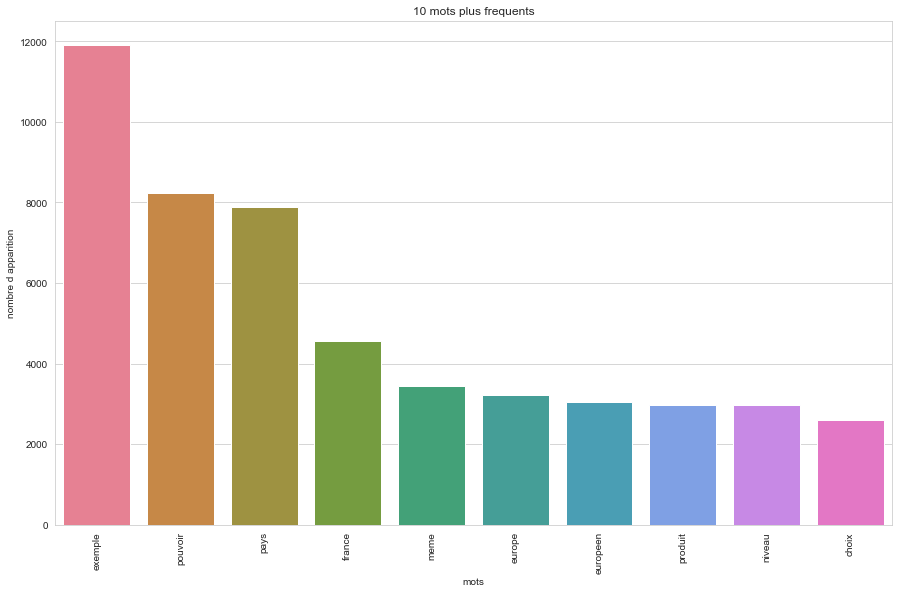

In [11]:
sns.set_style('whitegrid')
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 mots plus frequents')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('mots')
    plt.ylabel('nombre d apparition')
    plt.show()

list_for_count_vectorizer = []
for index in range(len(trans_eco_df[question])):
    list_for_count_vectorizer.append(' '.join(trans_eco_df[question][index]))
    
count_vectorizer = CountVectorizer()
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(list_for_count_vectorizer)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### Text summary

In [12]:
def concat_propal(data,col):
    text_to_summarize = ""
    
    for sentence in data[col]:
        try :
            text_to_summarize = text_to_summarize + sentence + "."
        except:
            continue
    
    return text_to_summarize

def summarize_col(data,col):
    
    text_to_summarize = ""
    
    for sentence in data[col]:
        try :
            text_to_summarize = text_to_summarize + sentence + "."
        except:
            continue
        
    print("done text_to_summarize")
    
    return summarize(text=text_to_summarize,ratio=0.0002), text_to_summarize
  
summary, text_to_summarize = summarize_col(trans_eco_df, "QUXVlc3Rpb246MTYw - Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?")
summary

### Keyword

In [13]:
sum_text = concat_propal(trans_eco_df, "QUXVlc3Rpb246MTYw - Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?")
keywords = textrank.extractKeyphrases(sum_text)
keywords

### Word Embedding

In [14]:
sorted_tf_idf_dict = {k: v for k, v in sorted(dict_tf_idf.items(), key=lambda item: item[1],reverse=True)}
keys = list(pd.Series(sorted_tf_idf_dict)[:200].index)

tokens=[]
for index in range(len(trans_eco_df[question])):
    if trans_eco_df[question][index]:
        temp = []
        for word in trans_eco_df[question][index]:
            if word in keys:
                temp.append(word)
        tokens.append(temp)

In [15]:
model = word2vec.Word2Vec(tokens)

In [16]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        if len(word)>3:
            tokens.append(model[word])
            labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\a2c18\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


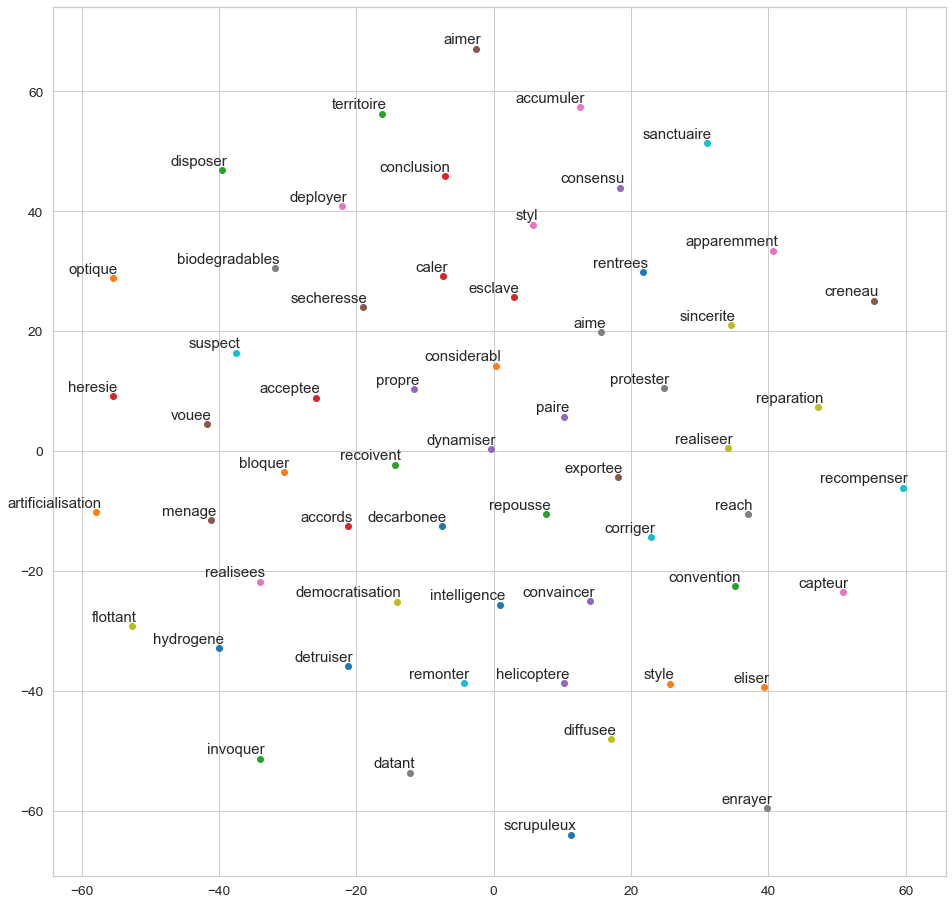

In [17]:
tsne_plot(model)

### LDA

In [18]:
warnings.simplefilter("ignore", DeprecationWarning)

# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 8
number_words = 6
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
pays montrer europeen choix ecologiqu exemplaire

Topic #1:
exemple lecon plutot appliquer fonctionne place

Topic #2:
pouvoir france meme pays monde falloir

Topic #3:
transport energie marchandise camion taxer hydrogene

Topic #4:
politique donner partager europeens engagement choix

Topic #5:
produit europe importation respecter taxe pays

Topic #6:
niveau pouvoir environnement france politique europeen

Topic #7:
bien propre france chose etat francai


### WordCloud

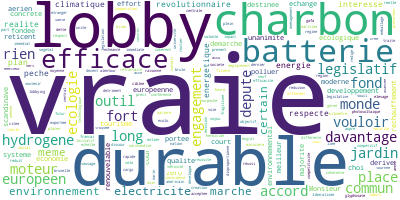

In [19]:
# Join the different processed titles together.
wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')# Generate a word cloud
wordcloud.generate(string_of_corpus)# Visualize the word cloud
wordcloud.to_image()